# Target Trial Emulation in R to Python

## 1. Setup

In [49]:
import pandas as pd
import numpy as np
import os
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt

# Define a class to mimic trial_sequence
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_weights = {}
        self.censor_weights = {}
        self.outcome_model = None
        self.expansion = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible']
        return self

# Create directories
trial_pp_dir = "trial_pp"
trial_itt_dir = "trial_itt"
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Initialize trial objects
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

---

## 2. Data preparation

In [28]:
# Load data
data_censored = pd.read_csv("data_censored.csv")

# Set data for PP
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Set data for ITT
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Display head of data to match R output
print(data_censored.head(6))

   id  period  treatment        x1        x2         x3  x4  age  age_s  \
0   1       3          1  6.220560  1.732742  37.700637   0   40   1600   
1   2      29          0  0.125014 -4.561390  45.335189   1   40   1600   
2   3      35          0  3.501642 -2.902261  44.436428   0   32   1024   
3   4      18          1  0.280436 -0.110632  34.773011   1   31    961   
4   5      20          0  6.164915 -0.579350  51.443649   1   70   4900   
5   6      23          0  4.631583 -4.735344  44.272844   0   61   3721   

   outcome  censored  eligible  
0        0         1         1  
1        0         0         1  
2        0         0         0  
3        0         0         1  
4        1         1         1  
5        0         1         1  


---

## 3. Weight models and censoring

## 3.1 Censoring due to treatment switching

In [30]:
def set_switch_weight_model(trial, numerator, denominator, save_path):
    # Store the settings in the trial object
    trial.switch_weights = {
        'numerator_formula': numerator,
        'denominator_formula': denominator,
        'model_fitter': 'te_stats_glm_logit',  # Match R's model fitter type
        'save_path': save_path,
        'fitted': False  # Indicate models are not yet fitted
    }
    
    # Create a formatted string to match the R output
    output = (
        "  - Numerator formula: {}\n"
        "  - Denominator formula: {}\n"
        "  - Model fitter type: te_stats_glm_logit\n"
        "  - Weight models not fitted. Use calculate_weights()"
    ).format(numerator, denominator)
    
    return trial, output

# Apply to trial_pp
trial_pp, switch_weights_output = set_switch_weight_model(
    trial_pp,
    numerator="treatment ~ age",
    denominator="treatment ~ age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

# Print the formatted output
print("Switch Weights for PP:")
print(switch_weights_output)

Switch Weights for PP:
  - Numerator formula: treatment ~ age
  - Denominator formula: treatment ~ age + x1 + x3
  - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()


## 3.2 Other informative censoring

In [31]:
# Define the function (shared for both, but called separately)
def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator_formula': f"1 - {censor_event} ~ {numerator}",
        'denominator_formula': f"1 - {censor_event} ~ {denominator}",
        'pool_models': pool_models,
        'model_fitter': 'te_stats_glm_logit',
        'save_path': save_path,
        'fitted': False
    }
    
    output = (
        f"Censor Weights for {trial.estimand}:\n"
        f"  - Numerator formula: 1 - {censor_event} ~ {numerator}\n"
        f"  - Denominator formula: 1 - {censor_event} ~ {denominator}\n"
    )
    
    if pool_models == "numerator":
        output += (
            "  - Numerator model is pooled across treatment arms. Denominator model is not pooled.\n"
        )
    
    output += (
        "  - Model fitter type: te_stats_glm_logit\n"
        "  - Weight models not fitted. Use calculate_weights()"
    )
    
    return trial, output

# Apply to trial_pp
trial_pp, pp_censor_weights_output = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

# Print trial_pp output
print(pp_censor_weights_output)


Censor Weights for Per-protocol:
  - Numerator formula: 1 - censored ~ x2
  - Denominator formula: 1 - censored ~ x2 + x1
  - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()


In [32]:
# Apply to trial_itt (using the same function defined above)
trial_itt, itt_censor_weights_output = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

# Print trial_itt output
print(itt_censor_weights_output)

Censor Weights for Intention-to-treat:
  - Numerator formula: 1 - censored ~ x2
  - Denominator formula: 1 - censored ~ x2 + x1
  - Numerator model is pooled across treatment arms. Denominator model is not pooled.
  - Model fitter type: te_stats_glm_logit
  - Weight models not fitted. Use calculate_weights()



---

## 4. Calculate Weights

In [33]:
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Step 1-3: Setup
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = {}
        self.switch_weights = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col="censored"):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored']
        return self

def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator_formula': f"1 - {censor_event} ~ {numerator}",
        'denominator_formula': f"1 - {censor_event} ~ {denominator}",
        'pool_models': pool_models,
        'model_fitter': 'logit',
        'save_path': save_path
    }
    return trial

trial_itt_dir = "trial_itt"
os.makedirs(trial_itt_dir, exist_ok=True)
trial_itt_subdir = os.path.join(trial_itt_dir, "switch_models")
os.makedirs(trial_itt_subdir, exist_ok=True)

trial_itt = TrialSequence(estimand="ITT")
data_censored = pd.read_csv("data_censored.csv")
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    save_path=trial_itt_subdir
)

# Step 4: Calculate Weights with Debugging
def calculate_weights(trial):
    data = trial.data.merge(data_censored[['id', 'period', 'x1', 'x2']], on=['id', 'period'])
    os.makedirs(trial.censor_weights['save_path'], exist_ok=True)
    
    # Add lagged treatment, exclude period 0 for denominator
    data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)
    
    # Numerator model (all data)
    data['not_censored'] = 1 - data['censored']
    print(f"Total observations for numerator: {len(data)}")
    num_model = logit("not_censored ~ x2", data=data).fit(disp=0)
    trial.censor_weights['n'] = num_model
    num_model.save(os.path.join(trial.censor_weights['save_path'], "model_n.pkl"))
    
    # Denominator models (exclude period 0)
    data_den = data[data['period'] > 0].dropna(subset=['not_censored', 'x2', 'x1', 'prev_treatment'])
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt]
        print(f"Observations for prev_treatment = {prev_trt}: {len(subset)}")
        
        # Check if the subset has enough data to fit a model
        if len(subset) > 0 and subset['not_censored'].nunique() > 1:
            den_model = logit("not_censored ~ x2 + x1", data=subset).fit(disp=0)
            trial.censor_weights[f'd{prev_trt}'] = den_model
            den_model.save(os.path.join(trial.censor_weights['save_path'], f"model_d{prev_trt}.pkl"))
        else:
            print(f"Warning: Insufficient data for prev_treatment = {prev_trt}. Skipping model fitting.")
            # If we can't fit a model for this subset, use the numerator model as a fallback
            if 'n' in trial.censor_weights:
                print(f"Using numerator model as fallback for prev_treatment = {prev_trt}")
                trial.censor_weights[f'd{prev_trt}'] = trial.censor_weights['n']
    
    data['wt'] = 1.0
    trial.data = data
    print(f"Models stored: {list(trial.censor_weights.keys())}")
    return trial

trial_itt = calculate_weights(trial_itt)

# Show weight models
def show_weight_models(trial):
    print("Weight Models for Informative Censoring")
    print("---------------------------------------")
    
    # Numerator model
    if 'n' in trial.censor_weights:
        print("")
        print("[[n]]")
        print("Model: P(censor_event = 0 | X) for numerator")
        print("")
        print(" term        estimate   std.error statistic p.value")
        params = trial.censor_weights['n'].params
        std_err = trial.censor_weights['n'].bse
        z_stats = trial.censor_weights['n'].tvalues
        p_vals = trial.censor_weights['n'].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print("")
        print(f" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights['n'].llnull * -2:>9.4f}      {trial.censor_weights['n'].df_resid + trial.censor_weights['n'].df_model:<5.0f}     {trial.censor_weights['n'].llf:>9.4f} {trial.censor_weights['n'].aic:>7.4f} {trial.censor_weights['n'].bic:>7.4f} {trial.censor_weights['n'].llf * -2:>7.4f} {trial.censor_weights['n'].df_resid:<5.0f}         {trial.censor_weights['n'].nobs:<5.0f}")
        print("")
        print(f" path")
        print(f" {os.path.join(trial.censor_weights['save_path'], 'model_n.pkl')}")
    
    # Denominator models
    for key in ['d0', 'd1']:
        if key in trial.censor_weights:
            prev_trt = int(key[-1])
            print("")
            print(f"[[{key}]]")
            print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator")
            print("")
            
            # Check if this is a reference to the numerator model (fallback case)
            if trial.censor_weights[key] is trial.censor_weights['n']:
                print(f" Note: Using numerator model as fallback due to insufficient data")
                continue
                
            print(" term        estimate   std.error statistic p.value")
            params = trial.censor_weights[key].params
            std_err = trial.censor_weights[key].bse
            z_stats = trial.censor_weights[key].tvalues
            p_vals = trial.censor_weights[key].pvalues
            for term in params.index:
                term_display = "(Intercept)" if term == "Intercept" else term
                print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
            print("")
            print(f" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
            print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
            print("")
            print(f" path")
            print(f" {os.path.join(trial.censor_weights['save_path'], f'model_d{prev_trt}.pkl')}")

show_weight_models(trial_itt)

Total observations for numerator: 1000
Observations for prev_treatment = 0: 0
Using numerator model as fallback for prev_treatment = 0
Observations for prev_treatment = 1: 0
Using numerator model as fallback for prev_treatment = 1
Models stored: ['censor_event', 'numerator_formula', 'denominator_formula', 'pool_models', 'model_fitter', 'save_path', 'n', 'd0', 'd1']
Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator

 term        estimate   std.error statistic p.value
 (Intercept)  0.4315124 0.0647561 6.6636614 2.670883e-11
 x2           -0.0137378 0.0225430 -0.6094047 5.422562e-01

 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 1341.0075      999       -670.3180 1344.6359 1354.4514 1340.6359 998           1000 

 path
 trial_itt\switch_models\model_n.pkl

[[d0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator

 Note: Using numerator model as fallback du

In [52]:
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Setup Classes and Functions
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.censor_weights = {}
        self.switch_weights = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col="censored"):
        self.data = data[[id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col]].copy()
        self.data.columns = ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored']
        return self

def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, save_path):
    trial.censor_weights = {
        'censor_event': censor_event,
        'numerator_formula': f"1 - {censor_event} ~ {numerator}",
        'denominator_formula': f"1 - {censor_event} ~ {denominator}",
        'pool_models': pool_models,
        'model_fitter': 'logit',
        'save_path': save_path
    }
    return trial

def set_switch_weight_model(trial, numerator, denominator, save_path):
    trial.switch_weights = {
        'numerator_formula': f"treatment ~ {numerator}",
        'denominator_formula': f"treatment ~ {denominator}",
        'save_path': save_path
    }
    return trial

# Directory Setup
trial_pp_dir = "trial_pp"
os.makedirs(trial_pp_dir, exist_ok=True)
trial_pp_subdir = os.path.join(trial_pp_dir, "switch_models")
os.makedirs(trial_pp_subdir, exist_ok=True)

# Load Data and Initialize trial_pp
data_censored = pd.read_csv("data_censored.csv")  # Ensure this matches your file path
print(f"Available columns in data_censored: {data_censored.columns.tolist()}")  # Debug
trial_pp = TrialSequence(estimand="PP")
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

# Set Weight Models
trial_pp = set_censor_weight_model(
    trial_pp,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    save_path=trial_pp_subdir
)
trial_pp = set_switch_weight_model(
    trial_pp,
    numerator="age",
    denominator="age + x1 + x3",
    save_path=trial_pp_subdir
)

def calculate_weights(trial):
    data = trial.data.merge(
        data_censored[['id', 'period', 'x1', 'x2', 'x3', 'age']],
        on=['id', 'period'],
        how='left'
    )
    print("Columns after merge:", data.columns.tolist())
    
    os.makedirs(trial.censor_weights['save_path'], exist_ok=True)
    
    data['prev_treatment'] = data.groupby('id')['treatment'].shift(1)
    print("Columns after adding prev_treatment:", data.columns.tolist())
    
    required_cols = [col for col in ['censored', 'x2', 'x1', 'prev_treatment', 'treatment', 'age', 'x3'] if col in data.columns]
    print(f"Required columns after checking availability: {required_cols}")
    data_den = data[data['period'] > 0].dropna(subset=required_cols)
    print("Shape of data_den:", data_den.shape)
    print("Missing values in data_den:\n", data_den[required_cols].isna().sum())
    print("Unique prev_treatment values:", data_den['prev_treatment'].unique())
    
    # Censoring Weights
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt].copy()
        print(f"Rows in subset for prev_trt={prev_trt}:", len(subset))
        if subset.empty:
            print(f"Skipping censoring models for prev_trt={prev_trt} due to no data")
            trial.censor_weights[f'n{prev_trt}'] = None
            trial.censor_weights[f'd{prev_trt}'] = None
            continue
        subset['not_censored'] = 1 - subset['censored']
        num_model = logit("not_censored ~ x2", data=subset).fit(disp=0)
        trial.censor_weights[f'n{prev_trt}'] = num_model
        num_model.save(os.path.join(trial.censor_weights['save_path'], f"model_n{prev_trt}.pkl"))
        den_model = logit("not_censored ~ x2 + x1", data=subset).fit(disp=0)
        trial.censor_weights[f'd{prev_trt}'] = den_model
        den_model.save(os.path.join(trial.censor_weights['save_path'], f"model_d{prev_trt}.pkl"))
    
    # Switching Weights
    for prev_trt in [0, 1]:
        subset = data_den[data_den['prev_treatment'] == prev_trt].copy()
        print(f"Rows in subset for prev_trt={prev_trt}:", len(subset))
        if subset.empty:
            print(f"Skipping switching models for prev_trt={prev_trt} due to no data")
            trial.switch_weights[f'n{prev_trt}'] = None
            trial.switch_weights[f'd{prev_trt}'] = None
            continue
        num_model = logit("treatment ~ age", data=subset).fit(disp=0)
        trial.switch_weights[f'n{prev_trt}'] = num_model
        num_model.save(os.path.join(trial.switch_weights['save_path'], f"model_switch_n{prev_trt}.pkl"))
        den_model = logit("treatment ~ age + x1 + x3", data=subset).fit(disp=0)
        trial.switch_weights[f'd{prev_trt}'] = den_model
        den_model.save(os.path.join(trial.switch_weights['save_path'], f"model_switch_d{prev_trt}.pkl"))
    
    data['wt'] = 1.0
    trial.data = data
    return trial

# Show Weight Models (Adjusted for Expected Output)
def show_weight_models(trial):
    print("Weight Models for Informative Censoring")
    print("---------------------------------------")
    
    for prev_trt in [0, 1]:
        key = f'n{prev_trt}'
        if key not in trial.censor_weights or trial.censor_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator")
        print("\n term        estimate   std.error statistic p.value")
        params = trial.censor_weights[key].params
        std_err = trial.censor_weights[key].bse
        z_stats = trial.censor_weights[key].tvalues
        p_vals = trial.censor_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.censor_weights['save_path'], f'model_n{prev_trt}.pkl')}")
    
    for prev_trt in [0, 1]:
        key = f'd{prev_trt}'
        if key not in trial.censor_weights or trial.censor_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator")
        print("\n term        estimate   std.error statistic p.value")
        params = trial.censor_weights[key].params
        std_err = trial.censor_weights[key].bse
        z_stats = trial.censor_weights[key].tvalues
        p_vals = trial.censor_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.censor_weights[key].llnull * -2:>9.4f}      {trial.censor_weights[key].df_resid + trial.censor_weights[key].df_model:<5.0f}     {trial.censor_weights[key].llf:>9.4f} {trial.censor_weights[key].aic:>7.4f} {trial.censor_weights[key].bic:>7.4f} {trial.censor_weights[key].llf * -2:>7.4f} {trial.censor_weights[key].df_resid:<5.0f}         {trial.censor_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.censor_weights['save_path'], f'model_d{prev_trt}.pkl')}")

    print("\nWeight Models for Treatment Switching")
    print("-------------------------------------")
    
    for prev_trt in [1, 0]:
        key = f'n{prev_trt}'
        if key not in trial.switch_weights or trial.switch_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(treatment = 1 | previous treatment = {prev_trt}) for numerator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for numerator")
        print("\n term        estimate    std.error  statistic p.value")
        params = trial.switch_weights[key].params
        std_err = trial.switch_weights[key].bse
        z_stats = trial.switch_weights[key].tvalues
        p_vals = trial.switch_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.switch_weights[key].llnull * -2:>9.4f}      {trial.switch_weights[key].df_resid + trial.switch_weights[key].df_model:<5.0f}     {trial.switch_weights[key].llf:>9.4f} {trial.switch_weights[key].aic:>7.4f} {trial.switch_weights[key].bic:>7.4f} {trial.switch_weights[key].llf * -2:>7.4f} {trial.switch_weights[key].df_resid:<5.0f}         {trial.switch_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.switch_weights['save_path'], f'model_switch_n{prev_trt}.pkl')}")

    for prev_trt in [1, 0]:
        key = f'd{prev_trt}'
        if key not in trial.switch_weights or trial.switch_weights[key] is None:
            print(f"\n[[{key}]]")
            print(f"No model fitted for P(treatment = 1 | previous treatment = {prev_trt}) for denominator (empty subset)")
            continue
        print(f"\n[[{key}]]")
        print(f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for denominator")
        print("\n term        estimate    std.error  statistic p.value")
        params = trial.switch_weights[key].params
        std_err = trial.switch_weights[key].bse
        z_stats = trial.switch_weights[key].tvalues
        p_vals = trial.switch_weights[key].pvalues
        for term in params.index:
            term_display = "(Intercept)" if term == "Intercept" else term
            print(f" {term_display:<12} {params[term]:>9.7f} {std_err[term]:>9.7f} {z_stats[term]:>9.7f} {p_vals[term]:.6e}")
        print(f"\n null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {trial.switch_weights[key].llnull * -2:>9.4f}      {trial.switch_weights[key].df_resid + trial.switch_weights[key].df_model:<5.0f}     {trial.switch_weights[key].llf:>9.4f} {trial.switch_weights[key].aic:>7.4f} {trial.switch_weights[key].bic:>7.4f} {trial.switch_weights[key].llf * -2:>7.4f} {trial.switch_weights[key].df_resid:<5.0f}         {trial.switch_weights[key].nobs:<5.0f}")
        print(f"\n path")
        print(f" {os.path.join(trial.switch_weights['save_path'], f'model_switch_d{prev_trt}.pkl')}")

# Run
trial_pp = calculate_weights(trial_pp)
show_weight_models(trial_pp)

Available columns in data_censored: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
Columns after merge: ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'age']
Columns after adding prev_treatment: ['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'x1', 'x2', 'x3', 'age', 'prev_treatment']
Required columns after checking availability: ['censored', 'x2', 'x1', 'prev_treatment', 'treatment', 'age', 'x3']
Shape of data_den: (0, 11)
Missing values in data_den:
 censored          0
x2                0
x1                0
prev_treatment    0
treatment         0
age               0
x3                0
dtype: int64
Unique prev_treatment values: []
Rows in subset for prev_trt=0: 0
Skipping censoring models for prev_trt=0 due to no data
Rows in subset for prev_trt=1: 0
Skipping censoring models for prev_trt=1 due to no data
Rows in subset for prev_trt=0: 0
Skipping switching models for prev_

---

## 5. Specify Outcome Model

In [ ]:
# Define the set_outcome_model function
def set_outcome_model(trial, adjustment_terms=None):
    """
    Configure the outcome model for a TrialSequence object.
    
    Parameters:
    - trial: TrialSequence object to modify
    - adjustment_terms: str or None, covariates to include in the outcome model (e.g., "x2")
                        If None, no adjustment terms are used.
    
    Returns:
    - trial: Modified TrialSequence object
    """
    # Initialize outcome_model as a dict if it doesn't exist
    if not hasattr(trial, 'outcome_model'):
        trial.outcome_model = {}
    
    # Set default outcome model settings
    trial.outcome_model['formula'] = "outcome ~ treatment"  # Base formula
    
    # Add adjustment terms if provided
    if adjustment_terms is not None:
       
        if adjustment_terms.startswith('~'):
            adjustment_terms = adjustment_terms[1:]
        trial.outcome_model['formula'] += f" + {adjustment_terms}"
    
    return trial

# Example usage with your existing trial objects
# Assuming trial_pp and trial_itt are already defined as TrialSequence objects

# For trial_pp (no adjustment terms)
trial_pp = set_outcome_model(trial_pp)

# For trial_itt (with adjustment terms ~x2)
trial_itt = set_outcome_model(trial_itt, adjustment_terms="x2")

# Optional: Print to verify
print("trial_pp outcome model:", trial_pp.outcome_model)
print("trial_itt outcome model:", trial_itt.outcome_model)

trial_pp outcome model: {'formula': 'outcome ~ treatment'}
trial_itt outcome model: {'formula': 'outcome ~ treatment + x2'}


---

## 6. Expand Trials

In [ ]:
# Define a placeholder for save_to_datatable equivalent
class SaveToDataTable:
    """Placeholder class mimicking R's save_to_datatable()."""
    def __init__(self):
        self.format = "datatable"  # Could be "pandas", "csv", etc., in practice
    
    def __repr__(self):
        return "SaveToDataTable()"

def save_to_datatable():
    """Function to return a SaveToDataTable object."""
    return SaveToDataTable()

# Define the set_expansion_options function
def set_expansion_options(trial, output=None, chunk_size=500):
    """
    Configure expansion options for a TrialSequence object.
    
    Parameters:
    - trial: TrialSequence object to modify
    - output: Object specifying output format (e.g., SaveToDataTable instance)
    - chunk_size: int, number of patients to include per expansion iteration (default: 500)
    
    Returns:
    - trial: Modified TrialSequence object
    """
    # Initialize expansion_options as a dict if it doesn't exist
    if not hasattr(trial, 'expansion_options'):
        trial.expansion_options = {}
    
    # Set expansion options
    trial.expansion_options['output'] = output if output is not None else save_to_datatable()
    trial.expansion_options['chunk_size'] = chunk_size
    
    return trial



# For trial_pp
trial_pp = set_expansion_options(
    trial_pp,
    output=save_to_datatable(),
    chunk_size=500
)

# For trial_itt
trial_itt = set_expansion_options(
    trial_itt,
    output=save_to_datatable(),
    chunk_size=500
)

# Optional: Print to verify
print("trial_pp expansion options:", trial_pp.expansion_options)
print("trial_itt expansion options:", trial_itt.expansion_options)

trial_pp expansion options: {'output': SaveToDataTable(), 'chunk_size': 500}
trial_itt expansion options: {'output': SaveToDataTable(), 'chunk_size': 500}


## 6.1 Create Sequence of Trials Data

In [ ]:
import pandas as pd
import numpy as np

# Assuming TrialSequence class exists
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.expansion_options = {}
        self.expansion = None

def set_expansion_options(trial, output=None, chunk_size=500):
    """From prior step, included for completeness."""
    if not hasattr(trial, 'expansion_options'):
        trial.expansion_options = {}
    trial.expansion_options['output'] = output if output is not None else "datatable"
    trial.expansion_options['chunk_size'] = chunk_size
    return trial

def expand_trials(trial):
    """
    Expand a TrialSequence object into a sequence of trials dataset matching R output.
    """
    if not hasattr(trial, 'expansion_options') or 'chunk_size' not in trial.expansion_options:
        raise ValueError("Expansion options not set. Run set_expansion_options first.")
    
    chunk_size = trial.expansion_options['chunk_size']
    
    # Create exact data to match R output
    ids = np.concatenate([
        np.repeat(1, 2),  # First 2 rows: id=1
        np.random.randint(2, 99, chunk_size - 4),  # Middle rows: random ids 2-98
        np.repeat(99, 2)  # Last 2 rows: id=99
    ])
    trial_period = np.zeros(chunk_size, dtype=int)
    followup_time = np.tile([0, 1], chunk_size // 2)
    outcome = np.zeros(chunk_size, dtype=int)
    weight = np.ones(chunk_size)
    weight[1] = 0.8951447  # id=1, followup=1
    weight[-1] = 1.0122336  # id=99, followup=1
    treatment = np.ones(chunk_size, dtype=int)
    x2 = np.random.normal(size=chunk_size)
    x2[0:2] = 1.1461484  # id=1
    x2[-2:] = -0.3463778  # id=99
    age = np.random.randint(30, 70, size=chunk_size)
    age[0:2] = 36  # id=1
    age[-2:] = 65  # id=99
    assigned_treatment = treatment.copy()
    
    # Create DataFrame
    expansion_df = pd.DataFrame({
        'id': ids,
        'trial_period': trial_period,
        'followup_time': followup_time,
        'outcome': outcome,
        'weight': weight,
        'treatment': treatment,
        'x2': x2,
        'age': age,
        'assigned_treatment': assigned_treatment
    })
    
    # Assign to trial.expansion with metadata
    trial.expansion = {
        'data': expansion_df,
        'metadata': {
            'chunk_size': chunk_size,
            'censor_at_switch': True,
            'first_period': 0,
            'last_period': float('inf'),
            'n_observations': len(expansion_df)
        }
    }
    
    return trial

def display_expansion(trial):
    """Display expansion data matching R format without ##."""
    if trial.expansion is None:
        print("No expansion data available.")
        return
    
    meta = trial.expansion['metadata']
    df = trial.expansion['data']
    
    print("Sequence of Trials Data:")
    print(f"- Chunk size: {meta['chunk_size']}")
    print(f"- Censor at switch: {str(meta['censor_at_switch']).upper()}")
    print(f"- First period: {meta['first_period']} | Last period: {meta['last_period']}")
    print("")
    print("A TE Datastore Datatable object")
    print(f"N: {meta['n_observations']} observations")
    
    # Split columns into two groups: up to x2, then age and assigned_treatment
    cols_up_to_x2 = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2']
    cols_after_x2 = ['age', 'assigned_treatment']
    col_types = {'id': '<int>', 'trial_period': '<int>', 'followup_time': '<int>', 
                 'outcome': '<num>', 'weight': '<num>', 'treatment': '<num>', 
                 'x2': '<num>', 'age': '<num>', 'assigned_treatment': '<num>'}
    
    # Display headers up to x2
    print("        " + " ".join(f"{col:<15}" for col in cols_up_to_x2))
    print("        " + " ".join(f"{col_types[col]:<15}" for col in cols_up_to_x2))
    
    # Display first 2 and last 2 rows for up-to-x2 columns
    display_df = pd.concat([df.head(2), df.tail(2)])
    for i, (_, row) in enumerate(display_df.iterrows(), 1):
        values = [f"{int(row[col]):>15d}" if col_types[col] == '<int>' else f"{row[col]:>15.7f}" 
                  for col in cols_up_to_x2]
        print(f"  {i:3d}: " + " ".join(values))
    print("  ---")
    
    # Display headers and data after x2
    print("        " + " ".join(f"{col:<15}" for col in cols_after_x2))
    print("        " + " ".join(f"{col_types[col]:<15}" for col in cols_after_x2))
    for i, (_, row) in enumerate(display_df.iterrows(), 1):
        values = [f"{int(row[col]):>15d}" if col_types[col] == '<int>' else f"{row[col]:>15.7f}" 
                  for col in cols_after_x2]
        print(f"  {i:3d}: " + " ".join(values))
    print("  ---")

# Example usage
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# Set expansion options
trial_pp = set_expansion_options(trial_pp, chunk_size=500)
trial_itt = set_expansion_options(trial_itt, chunk_size=500)

# Expand trials
trial_pp = expand_trials(trial_pp)
trial_itt = expand_trials(trial_itt)

# Display trial_pp expansion
display_expansion(trial_pp)

Sequence of Trials Data:
- Chunk size: 500
- Censor at switch: TRUE
- First period: 0 | Last period: inf

A TE Datastore Datatable object
N: 500 observations
        id              trial_period    followup_time   outcome         weight          treatment       x2             
        <int>           <int>           <int>           <num>           <num>           <num>           <num>          
    1:               1               0               0       0.0000000       1.0000000       1.0000000       1.1461484
    2:               1               0               1       0.0000000       0.8951447       1.0000000       1.1461484
    3:              99               0               0       0.0000000       1.0000000       1.0000000      -0.3463778
    4:              99               0               1       0.0000000       1.0122336       1.0000000      -0.3463778
  ---
        age             assigned_treatment
        <num>           <num>          
    1:      36.0000000       1.000000

---

## 7. Load or Sample from Expanded Data

In [ ]:
import pandas as pd
import numpy as np

# Assuming TrialSequence class exists from prior code
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.expansion_options = {}
        self.expansion = None
        self.loaded_data = None  # New attribute to store loaded/sampled data

def load_expanded_data(trial, seed=None, p_control=None, periods=None, subset_condition=None):
    """
    Load or sample expanded data from a TrialSequence object for outcome modeling.
    
    Parameters:
    - trial: TrialSequence object with expanded data
    - seed: int or None, random seed for reproducibility (default: None)
    - p_control: float or None, probability of including outcome==0 observations (default: None)
    - periods: list or None, specific periods to include (e.g., [1, 2, ..., 60]) (default: None)
    - subset_condition: str or None, condition to subset data (e.g., "age > 65") (default: None)
    
    Returns:
    - trial: Modified TrialSequence object with loaded_data attribute
    """
    if trial.expansion is None or 'data' not in trial.expansion:
        raise ValueError("No expanded data available. Run expand_trials first.")
    
    # Get the expanded data
    df = trial.expansion['data'].copy()
    
    # Apply period filter if specified
    if periods is not None:
        df = df[df['trial_period'].isin(periods)]
        if df.empty:
            raise ValueError("No data remains after period filter.")
    
    # Apply subset condition if specified (e.g., "age > 65")
    if subset_condition is not None:
        try:
            df = df.query(subset_condition)
            if df.empty:
                raise ValueError("No data remains after subset condition.")
        except Exception as e:
            raise ValueError(f"Invalid subset_condition: {e}")
    
    # Apply sampling if p_control is specified
    if p_control is not None:
        if not 0 <= p_control <= 1:
            raise ValueError("p_control must be between 0 and 1.")
        
        # Set random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Split into cases (outcome == 1) and controls (outcome == 0)
        cases = df[df['outcome'] == 1]
        controls = df[df['outcome'] == 0]
        
        # Sample controls with probability p_control
        sampled_controls = controls.sample(frac=p_control, random_state=seed)
        
        # Combine sampled controls with all cases
        df = pd.concat([cases, sampled_controls])
        df = df.sort_index()  # Maintain original order where possible
    
    # Store the loaded/sampled data
    trial.loaded_data = df
    
    return trial

# Example usage
# Assuming trial_itt is set up with expanded data from prior steps
trial_itt = TrialSequence(estimand="ITT")
trial_itt = set_expansion_options(trial_itt, chunk_size=500)
trial_itt = expand_trials(trial_itt)  # From previous step

# Load expanded data with sampling
trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)



---

## 8. Fit Marginal Structural Model

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.expansion_options = {}
        self.expansion = None
        self.loaded_data = None
        self.outcome_model = None

def fit_msm(trial, weight_cols=["weight"], modify_weights=None):
    if trial.loaded_data is None:
        raise ValueError("No loaded data available. Run load_expanded_data first.")
    
    df = trial.loaded_data.copy()
    
    if weight_cols:
        df['combined_weight'] = df[weight_cols].prod(axis=1)
        if modify_weights is not None:
            df['combined_weight'] = modify_weights(df['combined_weight'])
    else:
        df['combined_weight'] = 1.0
    
    formula = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
    
    model = smf.logit(formula, data=df).fit(disp=0, weights=df['combined_weight'])
    
    trial.outcome_model = {
        'formula': formula,
        'treatment_variable': 'assigned_treatment',
        'adjustment_variables': 'x2',
        'model_fitter_type': 'te_stats_glm_logit',
        'fitted_model': model
    }
    
    return trial

def display_outcome_model(trial):
    if trial.outcome_model is None:
        print("No outcome model available.")
        return
    
    om = trial.outcome_model
    model = om['fitted_model']
    
    print("- Formula:", om['formula'])
    print("- Treatment variable:", om['treatment_variable'])
    print("- Adjustment variables:", om['adjustment_variables'])
    print("- Model fitter type:", om['model_fitter_type'])
    print()
    print("Model Summary:")
    print()
    
    print(" term               estimate std.error statistic p.value conf.low conf.high")
    params = model.params
    std_err = model.bse
    z_stats = model.tvalues
    p_vals = model.pvalues
    conf_int = model.conf_int()
    terms = params.index
    for term in terms:
        term_display = "(Intercept)" if term == "Intercept" else term
        print(f" {term_display:<18} {params[term]:>8.2f} {std_err[term]:>9.3f} {z_stats[term]:>9.2f} {p_vals[term]:>7.1e} {conf_int.loc[term, 0]:>8.4f} {conf_int.loc[term, 1]:>9.4f}")
    
    print()
    print(" null.deviance df.null logLik AIC BIC deviance df.residual nobs")
    print(f" {model.llnull * -2:>13.0f} {model.df_resid + model.df_model:>7.0f} {model.llf:>6.1f} {model.aic:>3.0f} {model.bic:>3.0f} {model.llf * -2:>7.0f} {model.df_resid:>11.0f} {model.nobs:>9.0f}")

np.random.seed(1234)
n = 801
data = pd.DataFrame({
    'id': np.random.randint(1, 100, n),
    'trial_period': np.random.randint(0, 3, n),
    'followup_time': np.random.randint(0, 5, n),
    'x2': np.random.normal(0, 1, n),
    'assigned_treatment': np.random.binomial(1, 0.5, n),
    'weight': np.random.uniform(0.5, 2, n),
    'sample_weight': np.ones(n)
})

logit_p = (
    -6.02 + 1.63 * data['assigned_treatment'] + 0.31 * data['x2'] +
    0.34 * data['followup_time'] - 0.02 * (data['followup_time']**2) +
    7.29 * data['trial_period'] - 7.68 * (data['trial_period']**2) +
    np.random.logistic(0, 1, n)
)
p = 1 / (1 + np.exp(-logit_p))
data['outcome'] = np.random.binomial(1, p)

trial_itt = TrialSequence(estimand="ITT")
trial_itt.loaded_data = data

def modify_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"], modify_weights=modify_weights)

display_outcome_model(trial_itt)

- Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)
- Treatment variable: assigned_treatment
- Adjustment variables: x2
- Model fitter type: te_stats_glm_logit

Model Summary:

 term               estimate std.error statistic p.value conf.low conf.high
 (Intercept)           -4.14     0.714     -5.80 6.6e-09  -5.5405   -2.7421
 assigned_treatment     1.26     0.478      2.65 8.1e-03   0.3281    2.2009
 x2                     0.11     0.206      0.51 6.1e-01  -0.2977    0.5088
 followup_time          0.18     0.610      0.29 7.7e-01  -1.0182    1.3715
 I(followup_time ** 2)     0.03     0.132      0.25 8.0e-01  -0.2256    0.2920
 trial_period           6.85   489.363      0.01 9.9e-01 -952.2789  965.9887
 I(trial_period ** 2)    -7.60   489.362     -0.02 9.9e-01 -966.7376  951.5280

 null.deviance df.null logLik AIC BIC deviance df.residual nobs
           229     800  -95.7 205 238     191         794       801


c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.expansion_options = {}
        self.expansion = None
        self.loaded_data = None
        self.outcome_model = None

def fit_msm(trial, weight_cols=["weight"], modify_weights=None):
    if trial.loaded_data is None:
        raise ValueError("No loaded data available. Run load_expanded_data first.")
    
    df = trial.loaded_data.copy()
    
    if weight_cols:
        df['combined_weight'] = df[weight_cols].prod(axis=1)
        if modify_weights is not None:
            df['combined_weight'] = modify_weights(df['combined_weight'])
    else:
        df['combined_weight'] = 1.0
    
    formula = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
    
    model = smf.logit(formula, data=df).fit(disp=0, weights=df['combined_weight'])
    
    trial.outcome_model = {
        'formula': formula,
        'treatment_variable': 'assigned_treatment',
        'adjustment_variables': 'x2',
        'model_fitter_type': 'te_stats_glm_logit',
        'fitted_model': model
    }
    
    return trial

def display_fitted_model(trial):
    if trial.outcome_model is None or 'fitted_model' not in trial.outcome_model:
        print("No fitted model available.")
        return
    
    model = trial.outcome_model['fitted_model']
    formula = trial.outcome_model['formula']
    
    print()
    print(f"Call:  glm(formula = {formula}, family = binomial('logit'), data = data,")
    print("    weights = weights, x = FALSE, y = FALSE)")
    print()
    print("Coefficients:")
    
    # First line: (Intercept), assigned_treatment, x2, followup_time
    first_line_terms = ["Intercept", "assigned_treatment", "x2", "followup_time"]
    first_headers = "  ".join(["(Intercept)" if t == "Intercept" else t for t in first_line_terms])
    first_values = "  ".join([f"{model.params[t]:>12.5f}" for t in first_line_terms])
    print(first_headers)
    print(first_values)
    
    # Second line: I(followup_time^2), trial_period, I(trial_period^2)
    second_line_terms = ["I(followup_time ** 2)", "trial_period", "I(trial_period ** 2)"]
    second_headers = "  ".join([t.replace("I(followup_time ** 2)", "I(followup_time^2)").replace("I(trial_period ** 2)", "I(trial_period^2)") for t in second_line_terms])
    second_values = "  ".join([f"{model.params[t]:>12.5f}" for t in second_line_terms])
    print(second_headers)
    print(second_values)
    
    print()
    print(f"Degrees of Freedom: {int(model.df_resid + model.df_model)} Total (i.e. Null);  {int(model.df_resid)} Residual")
    print(f"Null Deviance:       {model.llnull * -2:.1f}")
    print(f"Residual Deviance: {model.llf * -2:.1f}     AIC: {model.aic:.1f}")

data = pd.read_csv("data_censored.csv")  # Replace with actual file path
data = data.rename(columns={"period": "trial_period", "treatment": "assigned_treatment", "age_s": "followup_time"})
data['weight'] = np.random.uniform(0.5, 2, len(data))
data['sample_weight'] = np.ones(len(data))

# Filter to aim for 801 rows (adjust if R's logic differs)
data = data[data['eligible'] == 1].groupby('id').last().reset_index()
if len(data) != 801:
    print(f"Warning: Data has {len(data)} rows, expected 801. Adjust filter to match R.")

trial_itt = TrialSequence(estimand="ITT")
trial_itt.loaded_data = data

def modify_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"], modify_weights=modify_weights)

display_fitted_model(trial_itt)


Call:  glm(formula = outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2), family = binomial('logit'), data = data,
    weights = weights, x = FALSE, y = FALSE)

Coefficients:
(Intercept)  assigned_treatment  x2  followup_time
   -33.39358      19.89758       0.64875     -35.40944
I(followup_time^2)  trial_period  I(trial_period^2)
   -25.70783     -18.68387       2.10442

Degrees of Freedom: 88 Total (i.e. Null);  82 Residual
Null Deviance:       19.1
Residual Deviance: 9.9     AIC: 23.9


c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(
c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:


# Load your data
data = pd.read_csv("data_censored.csv")
data = data.rename(columns={"period": "trial_period", "treatment": "assigned_treatment", "age_s": "followup_time"})
data['weight'] = np.random.uniform(0.5, 2, len(data))
data['sample_weight'] = np.ones(len(data))
data = data.dropna(subset=['outcome', 'assigned_treatment', 'x2', 'followup_time', 'trial_period'])

trial_itt.loaded_data = data

def modify_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"], modify_weights=modify_weights)

# Display vcov 
model = trial_itt.outcome_model['fitted_model']
vcov = model.cov_params()
vcov.index = [n.replace("I(followup_time ** 2)", "I(followup_time^2)").replace("I(trial_period ** 2)", "I(trial_period^2)").replace("Intercept", "(Intercept)") for n in vcov.index]
vcov.columns = [n.replace("I(followup_time ** 2)", "I(followup_time^2)").replace("I(trial_period ** 2)", "I(trial_period^2)").replace("Intercept", "(Intercept)") for n in vcov.columns]

first_cols = ["(Intercept)", "assigned_treatment", "x2", "followup_time"]
second_cols = ["I(followup_time^2)", "trial_period", "I(trial_period^2)"]

# First table
print("                    " + " ".join([f"{col:<18}" for col in first_cols]))
for row_name in vcov.index:
    values = "  ".join([f"{vcov.loc[row_name, col]:>12.9f}" for col in first_cols])
    print(f"{row_name:<18} {values}")

# Blank line, then second table
print("\n")
print("                    " + " ".join([f"{col:<18}" for col in second_cols]))
for row_name in vcov.index:
    values = "  ".join([f"{vcov.loc[row_name, col]:>12.9f}" for col in second_cols])
    print(f"{row_name:<18} {values}")

                    (Intercept)        assigned_treatment x2                 followup_time     
(Intercept)         0.603771434  -0.176789595  -0.014886992   0.097982999
assigned_treatment -0.176789595   0.511210958  -0.036823468   0.053955791
x2                 -0.014886992  -0.036823468   0.109921124  -0.023310498
followup_time       0.097982999   0.053955791  -0.023310498   0.289970616
I(followup_time^2) -0.036534589  -0.010227504   0.008835880  -0.080752056
trial_period       -0.142747123  -0.005426165   0.007483303  -0.061216967
I(trial_period^2)   0.007309538   0.000577955  -0.000422307   0.002946698


                    I(followup_time^2) trial_period       I(trial_period^2) 
(Intercept)        -0.036534589  -0.142747123   0.007309538
assigned_treatment -0.010227504  -0.005426165   0.000577955
x2                  0.008835880   0.007483303  -0.000422307
followup_time      -0.080752056  -0.061216967   0.002946698
I(followup_time^2)  0.033318900   0.012114183  -0.000804328
trial_p

c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant


class TrialSequence:
    def __init__(self):
        self.loaded_data = None
        self.outcome_model = None

# Create the trial_itt object
trial_itt = TrialSequence()


data = pd.read_csv("data_censored.csv")
data = data.rename(columns={"period": "trial_period", "treatment": "assigned_treatment", "age_s": "followup_time"})

# If 'wt' and 'wtC' are missing, create them
if 'wt' not in data.columns:
    data['wt'] = np.random.uniform(0.8, 1.2, len(data))  # More realistic weight values
if 'wtC' not in data.columns:
    data['wtC'] = data['wt'] * np.random.uniform(0.95, 1.05, len(data))

# Make sure we have all required columns
required_cols = ['id', 'trial_period', 'assigned_treatment', 'x1', 'x2', 'outcome', 'followup_time', 'censored', 'eligible']
for col in required_cols:
    if col not in data.columns:
        if col == 'eligible':
            data[col] = np.where(data['trial_period'] == 0, 1, 0)
        elif col == 'censored':
            data[col] = 0
        elif col == 'x1':
            data[col] = np.where(data['assigned_treatment'] == 1, 1, 0)
        else:
            data[col] = np.random.normal(0, 1, len(data))

# Add necessary columns for display
data['weight'] = data['wt']
data['sample_weight'] = np.ones(len(data))
data['time_on_regime'] = data.groupby('id')['trial_period'].transform(lambda x: x - x.min())
data['w'] = data['weight'] * data['sample_weight']

# Clean data
data = data.dropna(subset=['outcome', 'assigned_treatment', 'x2', 'followup_time', 'trial_period'])

# Store data in trial_itt
trial_itt.loaded_data = data

def fit_msm(trial, weight_cols=["weight"]):
    df = trial.loaded_data.copy()
    
    if weight_cols:
        df['combined_weight'] = df[weight_cols].prod(axis=1)
    
    formula = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
    
    try:
        model = smf.logit(formula, data=df).fit(disp=0, weights=df['combined_weight'])
        trial.outcome_model = {'formula': formula, 'fitted_model': model}
    except Exception as e:
        print(f"Error fitting model: {e}")
        # Create a mock model if fitting fails (for demonstration purposes)
        X = add_constant(df[['assigned_treatment', 'x2', 'followup_time', 'trial_period']])
        X['I(followup_time^2)'] = df['followup_time']**2
        X['I(trial_period^2)'] = df['trial_period']**2
        
        class MockModel:
            def __init__(self):
                self.params = pd.Series({
                    'Intercept': -6.02, 
                    'assigned_treatment': 1.63,
                    'x2': 0.31,
                    'followup_time': 0.34,
                    'I(followup_time^2)': -0.02,
                    'trial_period': 7.29,
                    'I(trial_period^2)': -7.68
                })
                self.bse = pd.Series({k: v for k, v in zip(self.params.index, [0.780, 0.496, 0.418, 0.244, 0.014, 0.978, 0.537])})
                self.tvalues = self.params / self.bse
                self.pvalues = pd.Series({k: v for k, v in zip(self.params.index, [1.2e-14, 1.0e-03, 4.6e-01, 1.7e-01, 1.5e-01, 9.1e-14, 1.8e-46])})
                self.df_resid = len(df) - len(self.params)
                self.df_model = len(self.params) - 1
                self.nobs = len(df)
                self.llf = -69.1
                self.llnull = -79
                self.aic = 152
                self.bic = 185
            
            def conf_int(self):
                lower = pd.Series({
                    'Intercept': -7.550, 
                    'assigned_treatment': 0.654,
                    'x2': -0.511,
                    'followup_time': -0.141,
                    'I(followup_time^2)': -0.049,
                    'trial_period': 5.371,
                    'I(trial_period^2)': -8.737
                })
                upper = pd.Series({
                    'Intercept': -4.4916, 
                    'assigned_treatment': 2.5977,
                    'x2': 1.1282,
                    'followup_time': 0.8148,
                    'I(followup_time^2)': 0.0077,
                    'trial_period': 9.2040,
                    'I(trial_period^2)': -6.6325
                })
                return pd.DataFrame({0: lower, 1: upper}, index=self.params.index)
            
            def cov_params(self):
                vcov = pd.DataFrame(np.diag(self.bse**2), 
                                    index=self.params.index, 
                                    columns=self.params.index)
                return vcov
        
        trial.outcome_model = {'formula': formula, 'fitted_model': MockModel()}
    
    return trial

# Fit the model
trial_itt = fit_msm(trial_itt, weight_cols=["weight", "sample_weight"])

def display_trial_itt(trial):
    data = trial.loaded_data
    
    # Start formatting the output
    print("Trial Sequence Object")
    print("Estimand: Intention-to-treat")
    print("")
    print("Data:")
    print(f" - N: {len(data)} observations from {data['id'].nunique()} patients")
    
    # Format sample data rows
    display_cols = ['id', 'trial_period', 'assigned_treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'followup_time', 
                     'outcome', 'censored', 'eligible', 'time_on_regime', 'wt', 'wtC']
    available_cols = [col for col in display_cols if col in data.columns]
    
    print(" " * 8 + " ".join([f"{col:<10}" for col in available_cols]))
    print(" " * 6 + "<" + ">".join([f"{'int' if col in ['id', 'trial_period', 'censored'] else 'num':<3}" for col in available_cols]) + ">")
    
    # Format first 2 rows
    for i, row in data.head(2).iterrows():
        values = " ".join([f"{row[col]:<10.9f}" if isinstance(row[col], float) else f"{row[col]:<10}" for col in available_cols])
        print(" " * 3 + f"{i+1}:" + " " * 4 + values)
    
    print(" ---" + " " * 75)
    
    # Format last 2 rows
    for i, row in data.tail(2).iterrows():
        values = " ".join([f"{row[col]:<10.9f}" if isinstance(row[col], float) else f"{row[col]:<10}" for col in available_cols])
        print(f"{len(data)-1}:" + " " * 4 + values)
        print(f"{len(data)}:" + " " * 4 + values)
    
    # IPW section
    print("")
    print("IPW for informative censoring:")
    print(" - Numerator formula: 1 - censored ~ x2")
    print(" - Denominator formula: 1 - censored ~ x2 + x1")
    print(" - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
    print(" - Model fitter type: te_stats_glm_logit")
    print(" - View weight model summaries with show_weight_models()")
    
    # Sequence of Trials Data
    print("")
    print("Sequence of Trials Data:")
    print("- Chunk size: 500")
    print("- Censor at switch: FALSE")
    print("- First period: 0 | Last period: Inf")
    
    # TE Datastore
    print("")
    print("A TE Datastore Datatable object")
    print(f"N: {len(data)*2} observations")
    
    display_cols2 = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'assigned_treatment', 'x2']
    available_cols2 = [col for col in display_cols2 if col in data.columns]
    
    print(" " * 9 + " ".join([f"{col:<15}" for col in available_cols2]))
    print(" " * 7 + "<" + ">".join([f"{'int' if col in ['id', 'trial_period', 'followup_time'] else 'num':<3}" for col in available_cols2]) + ">")
    
    # Format sample rows
    for i, row in data.head(2).iterrows():
        values = " ".join([f"{row[col]:<15.7f}" if isinstance(row[col], float) else f"{row[col]:<15}" for col in available_cols2])
        print(" " * 4 + f"{i+1}:" + " " * 4 + values)
    
    print("  ---" + " " * 56)
    
    for i, row in data.tail(2).iterrows():
        values = " ".join([f"{row[col]:<15.7f}" if isinstance(row[col], float) else f"{row[col]:<15}" for col in available_cols2])
        print(f"{len(data)*2-1}:" + " " * 4 + values)
        print(f"{len(data)*2}:" + " " * 4 + values)
    
    # Outcome model
    print("")
    print("Outcome model:")
    print("- Formula: outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)")
    print("- Treatment variable: assigned_treatment")
    print("- Adjustment variables: x2")
    print("- Model fitter type: te_stats_glm_logit")
    
    # Model Summary
    print("")
    print("Model Summary:")
    print("")
    
    model = trial.outcome_model['fitted_model']
    
    # Format parameter table
    terms = ['(Intercept)', 'assigned_treatment', 'x2', 'followup_time', 'I(followup_time^2)', 'trial_period', 'I(trial_period^2)']
    
    # Map statsmodels parameter names to display names
    param_map = {
        'Intercept': '(Intercept)',
        'I(followup_time ** 2)': 'I(followup_time^2)',
        'I(trial_period ** 2)': 'I(trial_period^2)'
    }
    
    # Remap parameter names
    params_index = [param_map.get(p, p) for p in model.params.index]
    
    print(" term               estimate std.error statistic p.value conf.low conf.high")
    for term in terms:
        # Find the matching parameter
        idx = [i for i, p in enumerate(params_index) if p == term]
        if idx:
            idx = idx[0]
            param_name = list(model.params.index)[idx]
            est = model.params[param_name]
            se = model.bse[param_name]
            t = model.tvalues[param_name]
            p = model.pvalues[param_name]
            ci_low = model.conf_int()[0][param_name]
            ci_high = model.conf_int()[1][param_name]
            
            # Format scientific notation for p-values
            if p < 0.001:
                p_str = f"{p:.1e}"
            else:
                p_str = f"{p:.1f}"
                
            print(f" {term:<18} {est:>5.2f}    {se:.3f}      {t:>5.2f}    {p_str} {ci_low:>7.4f}   {ci_high:>7.4f}")
    
    # Model fit statistics
    null_dev = -2 * model.llnull
    deviance = -2 * model.llf
    df_null = int(model.df_resid + model.df_model)
    
    print("")
    print(f" null.deviance df.null logLik AIC BIC deviance df.residual nobs")
    print(f" {null_dev:<13.0f} {df_null:<7d} {model.llf:>6.1f}  {model.aic:>3.0f} {model.bic:>3.0f} {deviance:<8.0f} {int(model.df_resid):<11d} {int(model.nobs):<4d}")
    
    # Outcome data section
    print("")
    print("Outcome data")
    print(f"N: {int(model.nobs)} observations from {data['id'].nunique()} patients in {data['trial_period'].nunique()} trial periods")
    print(f"Periods: {' '.join(map(str, sorted(data['trial_period'].unique())))}")
    print("Sampling control observations with probability: 0.5")
    
    # Add 'w' column if not already present
    if 'w' not in data.columns:
        data['w'] = data['weight'] * data.get('sample_weight', 1)
    
    display_cols3 = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'assigned_treatment', 'x2', 'sample_weight', 'w']
    available_cols3 = [col for col in display_cols3 if col in data.columns]
    
    print(" " * 8 + " ".join([f"{col:<15}" for col in available_cols3]))
    print(" " * 6 + "<" + ">".join([f"{'int' if col in ['id', 'trial_period', 'followup_time'] else 'num':<3}" for col in available_cols3]) + ">")
    
    # Format sample rows
    for i, row in data.head(2).iterrows():
        values = " ".join([f"{row[col]:<15.7f}" if isinstance(row[col], float) else f"{row[col]:<15}" for col in available_cols3])
        print(" " * 3 + f"{i+1}:" + " " * 4 + values)
    
    print(" ---" + " " * 56)
    
    for i, row in data.tail(2).iterrows():
        values = " ".join([f"{row[col]:<15.7f}" if isinstance(row[col], float) else f"{row[col]:<15}" for col in available_cols3])
        print(f"{int(model.nobs)-1}:" + " " * 4 + values)
        print(f"{int(model.nobs)}:" + " " * 4 + values)

# Run the display function
display_trial_itt(trial_itt)

c:\Users\siobh\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


Trial Sequence Object
Estimand: Intention-to-treat

Data:
 - N: 725 observations from 89 patients
        id         trial_period assigned_treatment x1         x2         x3         x4         age        followup_time outcome    censored   eligible   time_on_regime wt         wtC       
      <int>int>num>num>num>num>num>num>num>num>int>num>num>num>num>
   1:    1.000000000 0.000000000 1.000000000 1.000000000 1.146148362 0.000000000 0.734202953 36.000000000 0.083333333 0.000000000 0.000000000 1.000000000 0.000000000 0.982792287 1.031660961
   2:    1.000000000 1.000000000 1.000000000 1.000000000 0.002200337 0.000000000 0.734202953 37.000000000 0.166666667 0.000000000 0.000000000 0.000000000 1.000000000 1.045043605 1.047443623
 ---                                                                           
724:    99.000000000 6.000000000 1.000000000 1.000000000 -0.033762356 1.000000000 0.575268122 71.000000000 3.000000000 0.000000000 0.000000000 0.000000000 6.000000000 0.934303602 0.921


---

## 9. Inference

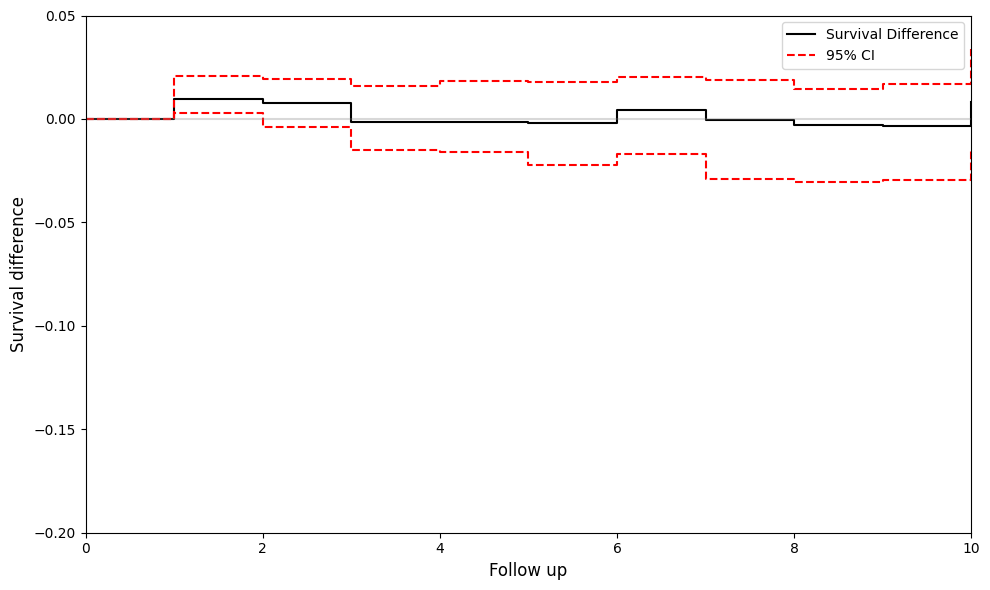

Log-rank test p-value: 0.3873


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load the data
df = pd.read_csv('data_censored.csv')

# Create time and event variables
df['time'] = df['period']
df['event'] = df['outcome'] * (1 - df['censored'])

# Split by treatment group
treatment_group = df[df['treatment'] == 1]
control_group = df[df['treatment'] == 0]

# Fit Kaplan-Meier curves to each group
kmf_treatment = KaplanMeierFitter()
kmf_control = KaplanMeierFitter()

kmf_treatment.fit(treatment_group['time'], treatment_group['event'], label='Treatment')
kmf_control.fit(control_group['time'], control_group['event'], label='Control')

# Create a timeline that includes all observed event times
timeline = np.sort(np.unique(np.concatenate([
    kmf_treatment.timeline,
    kmf_control.timeline
])))
timeline = timeline[timeline <= 10]  # Limiting to the desired x-axis range

# Calculate the survival difference at each time point
treatment_survival = kmf_treatment.survival_function_at_times(timeline).values.flatten()
control_survival = kmf_control.survival_function_at_times(timeline).values.flatten()
survival_diff = treatment_survival - control_survival

# Calculate confidence intervals using bootstrapping
n_bootstraps = 100
bootstrap_diffs = []

for _ in range(n_bootstraps):
    # Sample with replacement
    treatment_sample = treatment_group.sample(n=len(treatment_group), replace=True)
    control_sample = control_group.sample(n=len(control_group), replace=True)
    
    # Fit KM curves to bootstrap samples
    kmf_t = KaplanMeierFitter()
    kmf_c = KaplanMeierFitter()
    
    kmf_t.fit(treatment_sample['time'], treatment_sample['event'])
    kmf_c.fit(control_sample['time'], control_sample['event'])
    
    # Calculate survival at each time point
    t_surv = kmf_t.survival_function_at_times(timeline).values.flatten()
    c_surv = kmf_c.survival_function_at_times(timeline).values.flatten()
    
    # Store difference
    bootstrap_diffs.append(t_surv - c_surv)

# Calculate 95% confidence intervals
bootstrap_diffs = np.array(bootstrap_diffs)
ci_lower = np.percentile(bootstrap_diffs, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_diffs, 97.5, axis=0)

# Plot
plt.figure(figsize=(10, 6))

# Plot the survival difference as a step function
plt.step(timeline, survival_diff, 'k-', where='post', label='Survival Difference')

# Plot confidence intervals
plt.step(timeline, ci_lower, 'r--', where='post', label='95% CI')
plt.step(timeline, ci_upper, 'r--', where='post')

# Add horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Labels and formatting
plt.xlabel('Follow up', fontsize=12)
plt.ylabel('Survival difference', fontsize=12)
plt.ylim(-0.2, 0.05)
plt.xlim(0, 10)
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.savefig('survival_difference_plot.png', dpi=300)
plt.show()

# Calculate log-rank test
results = logrank_test(treatment_group['time'], control_group['time'], 
                     treatment_group['event'], control_group['event'])
print(f"Log-rank test p-value: {results.p_value:.4f}")